In [1]:
# imports

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read in words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# build stoi and itos mapping of all characters
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# building the dataset

# block size is the length of the context before the next token
block_size = 3
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train / val / test split
# train is used to train the parameters
# val is used to train the hyperparameters 
# test is used to evaluate the model at the end. 
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


In [5]:
# embedding matrix C of size 2. Embed the 27 characters to a 2 dimensional vector. 

C = torch.randn((27, 2))

# really easy way of pytorch indexing
# shape of (32, 3, 2)
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 2])

In [6]:
# hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# -1 tells Pytorch to infer what that dimension should be, in this case it has to be 32
# in torch, each torch vector is stored together, so when you do view and reshape, it does not recreate storage
# thus, do not want to use .cat or .unbind because those create new storage which is highly inefficient
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [9]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2

# always use cross_entropy instead of manually calculating the nll 
# 1. because for every manual step you would create new tensors and the calculations using this function 
# can be done with a fused kernel that is more efficient. tldr: forward pass is more efficient
# 2. Also, the backpropagation for this is much more efficient because this is treated as one step, 
# and there are analytical speedups. tldr: backward pass is more efficient
# 3. If you have a very large valued logit, the exponentiation of that value will become really large, 
# resulting in inf values and overflow. To fix this, PyTorch internally calculates the largest value
# of the logits, and subtracts it from all the logits because small logits are ok. This works because
# the add constant terms cancels in softmax. tldr: numerically stable. 

loss = F.cross_entropy(logits, Ytr)
loss

tensor(16.5698)

In [10]:
# combining it all together

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10))
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [11]:
# learning rate scheduler
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
# lri = []

In [12]:
lossi = []

In [13]:

for k in range(50000):
    # construct minibatch, so that we don't do forward pass on the whole dataset
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix])
    print(k, loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # lri.append(lre[k])
    lossi.append(loss.log10().item())

0 25.35284423828125
1 21.787883758544922
2 23.39776611328125
3 26.18975257873535
4 24.045738220214844
5 31.48182487487793
6 23.942703247070312
7 22.621322631835938
8 23.037431716918945
9 21.655288696289062
10 25.99203872680664
11 25.835918426513672
12 26.704851150512695
13 18.556249618530273
14 24.050840377807617
15 21.909690856933594
16 22.055500030517578
17 22.10549545288086
18 25.223642349243164
19 20.75716209411621
20 23.86077308654785
21 20.444162368774414
22 23.562692642211914
23 22.42396354675293
24 21.99799346923828
25 26.582826614379883
26 23.43158721923828
27 24.082197189331055
28 20.376943588256836
29 22.271326065063477
30 22.170516967773438
31 24.0455265045166
32 21.977252960205078
33 19.478527069091797
34 24.31014633178711
35 21.60055160522461
36 17.811580657958984
37 17.56849479675293
38 23.437583923339844
39 21.15589141845703
40 26.72190284729004
41 22.52751350402832
42 24.079145431518555
43 20.663698196411133
44 22.26163101196289
45 23.44839096069336
46 23.5909824371337

In [17]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1777, grad_fn=<NllLossBackward0>)

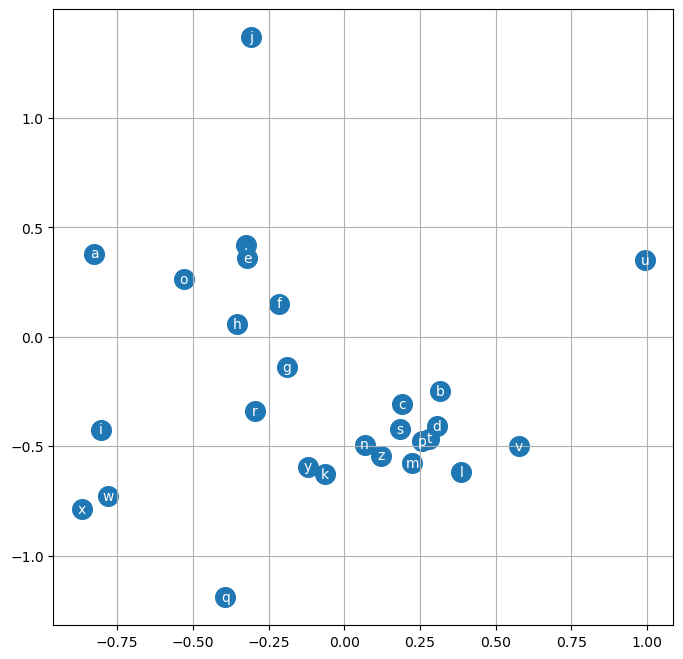

In [ ]:
# visualizing the 2D character embedding
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
# plt.axis('off')

In [25]:
# sampling from our model

for _ in range(20):
    out = []
    context = [0 ]* block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

layladalinlo.
abiyah.
mikkinganley.
aleeyaan.
kerbente.
kalha.
ani.
evmadon.
xioa.
valee.
zaylynn.
laylin.
ashaniulah.
ana.
beladrysen.
mika.
zuri.
kailyna.
naz.
quinleeawuadeyliella.
